יש לנו בטבלה לכל יוזר את היוזרים שהוא עוקב אחריהם
ננסה לעשות את הפענוח של כל יוזר לפי הנוסחא שקראתי במאמר
אני יוצרת טבלה חדשה בשביל להטעין את הגרף ולעשות ניתוח מספרי
השוואה בין 2 הDB האם המספרים תואמים
לראות תוצאות של נוסחה למיין לפי מי שקרוב יותר ל0
מי שיותר קרוב ל0 הוא סיכוי יותר גבוה שהוא בוט
בהינתן שהסמפרים נכונים

In [47]:
import pandas as pd
#calcultaion monitin for users to find bot based on the Twi-bot20 research
# reputation(u) = follower(u) / following(u)+follower(u)
import numpy as np

USERS_DATASET_PATH = 'twitter_human_bots_dataset/users_dataset.csv'
users_df = pd.read_csv(USERS_DATASET_PATH, index_col=0)
classes = users_df['account_type']                
features = users_df.drop(['account_type', 'default_profile', 'default_profile_image', 
                          'profile_background_image_url', 'profile_image_url', 'profile_image_path',
                          'profile_background_image_path', 'split'], axis = 1)
features = features.rename(columns={"friends_count": "following_count", "statuses_count": "tweets_count"})
reputation_set = features.get(['id', 'followers_count', 'following_count'])
reputation_set

id  followers_count  following_count
0        53779179              102              168
1       105916557               60              128
2       509788597              599              449
3        70601327              116              334
4       108999927            74448               18
...           ...              ...              ...
37433   223764929           257294              196
37434   222789645            74666               95
37435    80438218           255941              236
37436  1296642259          2678042               51
37437   236242525           471451            15967

[37438 rows x 3 columns]

In [48]:
column_list = list(reputation_set)
column_list.remove("id")
reputation_values = reputation_set.T.loc['followers_count'] / (reputation_set.T.loc['following_count']+reputation_set.T.loc['followers_count'])
reputation_set.insert(3, "reputation", reputation_values, True)
reputation_set

id  followers_count  following_count  reputation
0        53779179              102              168    0.377778
1       105916557               60              128    0.319149
2       509788597              599              449    0.571565
3        70601327              116              334    0.257778
4       108999927            74448               18    0.999758
...           ...              ...              ...         ...
37433   223764929           257294              196    0.999239
37434   222789645            74666               95    0.998729
37435    80438218           255941              236    0.999079
37436  1296642259          2678042               51    0.999981
37437   236242525           471451            15967    0.967242

[37438 rows x 4 columns]

In [49]:
sorted_reputation_set = reputation_set.sort_values(by=['reputation'])
sorted_reputation_set # all 0 are probably bot ? what about NaN?

id  followers_count  following_count  reputation
29716           365476963                0                8         0.0
33660  832724063445405696                0                2         0.0
16430  784318418862284800                0               21         0.0
13798  849647465989058564                0               23         0.0
14617           862629757                0               47         0.0
...                   ...              ...              ...         ...
37129  877398270519070720                0                0         NaN
37177  877405472747401217                0                0         NaN
37226  890854849218134016                0                0         NaN
37337  772503690649407488                0                0         NaN
37349  878072807107600384                0                0         NaN

[37438 rows x 4 columns]

In [50]:
sorted_reputation_set.dropna() # make calculation of NaN

id  followers_count  following_count  reputation
29716           365476963                0                8         0.0
33660  832724063445405696                0                2         0.0
16430  784318418862284800                0               21         0.0
13798  849647465989058564                0               23         0.0
14617           862629757                0               47         0.0
...                   ...              ...              ...         ...
4199   832027121430183936               23                0         1.0
31895          2944686696                6                0         1.0
11076  764449095213780992               27                0         1.0
23004           364005350                7                0         1.0
26874          3199812087               35                0         1.0

[36404 rows x 4 columns]

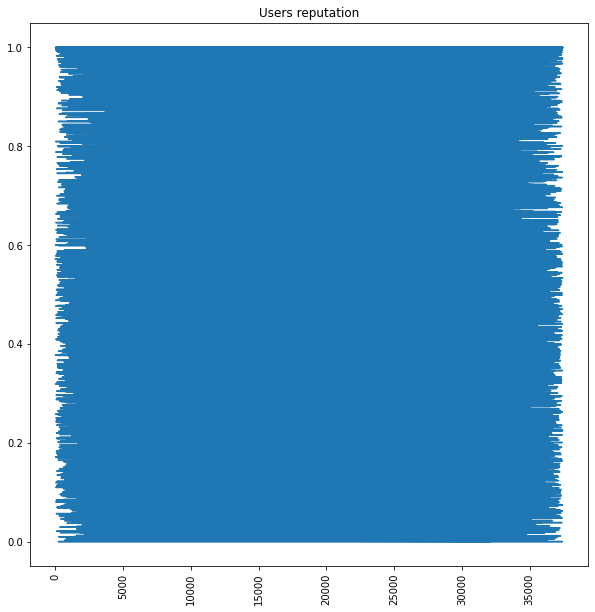

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sorted_reputation_set['reputation'].plot()
# sns.countplot(data=sorted_reputation_set, x='reputation', ax=ax)
plt.xticks(rotation=90)
ax.set_title('Users reputation')
plt.show()

In [1]:
import networkx as nx

follower_csv_file = r"twitter_human_bots_dataset/followers040522.csv"
follower_data = pd.read_csv(follower_csv_file)

# data overviwe
print(f"Rows Count: {follower_data.shape[0]}")
print(f"Features Count: {follower_data.shape[1]}")

#crate edges list from users and following list
users_following_data = follower_data.get(['followed_id','follower_id'])
users_following_data_withoutnone = users_following_data[users_following_data.followed_id != " "].dropna()
users_following_data_withoutnone = users_following_data_withoutnone[users_following_data_withoutnone.follower_id != " "].dropna()
users_following_data_withoutnone.to_csv(r'twitter_human_bots_dataset/edge_list.txt', header=None, index=None, sep=' ', mode='a')

C:\Dev_projects\TwitterBotsProject\venv\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Rows Count: 365546
Features Count: 12


In [2]:
from collections import defaultdict

users_dic = {}
counter_none = 0
for index, row in users_following_data_withoutnone.iterrows():
    try:
        if not isinstance(row['followed_id'], float) and not isinstance(row['follower_id'], float):
            user_id = int(float(row['followed_id']))
            following_id = int(float(row['follower_id']))
            if not users_dic.get(user_id) is None:
                if not following_id in users_dic[user_id]:
                    users_dic[user_id].append(following_id)
            else:
                users_dic[user_id] = []
                users_dic[user_id].append(following_id)
        else:
            counter_none+=1
    except Exception as e:
        print(index, e)
            
print(len(users_dic))
print("number of missing data: ", counter_none)

287327 could not convert string to float: ' . Line Sustyominers'
352863 could not convert string to float: ' E-mail : Admn.tipstrikinfo@gmail.com'
30
number of missing data:  90704


In [3]:
dic_followers_len = {}
for key, values in users_dic.items():
    dic_followers_len[key]= {"numbers of following":len(values)}
dic_followers_len

{410303609: {'numbers of following': 394},
 1210485564: {'numbers of following': 223},
 16967612: {'numbers of following': 1000},
 2157748434: {'numbers of following': 17},
 281473975: {'numbers of following': 1000},
 488512845: {'numbers of following': 1000},
 2952010610: {'numbers of following': 1000},
 169421357: {'numbers of following': 378},
 33289393: {'numbers of following': 75},
 15998107: {'numbers of following': 434},
 138600717: {'numbers of following': 1000},
 709540733456224256: {'numbers of following': 1000},
 16378198: {'numbers of following': 1000},
 250983398: {'numbers of following': 6},
 3245648312: {'numbers of following': 87},
 392228721: {'numbers of following': 25},
 537500546: {'numbers of following': 15},
 569581750: {'numbers of following': 293},
 155568211: {'numbers of following': 1000},
 877352477280043008: {'numbers of following': 1},
 1449155815: {'numbers of following': 1000},
 44051445: {'numbers of following': 561},
 26152058: {'numbers of following': 

In [78]:
edges_list_path = 'twitter_human_bots_dataset/edge_list.txt'
edges_list = open(edges_list_path, "r")
for line in edges_list:
    print(line)
edges_list.close() 
# G = nx.read_edgelist(edges_list)
# G.edges

53779179.0 7.81684125296169e+17

53779179.0 1.3868178429228603e+18

53779179.0 1.4686194932075725e+18

53779179.0 1.475611624992084e+18

53779179.0 103288329.0

53779179.0 1.4411093124331028e+18

53779179.0 3402076510.0

53779179.0 1.0822627674685316e+18

53779179.0 1.3919079784003912e+18

53779179.0 1.3073540428389868e+18

53779179.0 1.3776273118943685e+18

53779179.0 7.457927056120996e+17

53779179.0 1.352104356997423e+18

53779179.0 1.3465634645889106e+18

53779179.0 9.921582144761896e+17

53779179.0 1.2509531375459738e+18

53779179.0 1.2319893257489408e+18

53779179.0 532688190.0

53779179.0 1.1345604900453007e+18

53779179.0 1.2237175967275336e+18

53779179.0 8.201023940800184e+17

53779179.0 1.287437046903079e+18

53779179.0 1.3167473124300431e+18

53779179.0 1.31455978580369e+18

53779179.0 1.2705576925375898e+18

53779179.0 8.381293255641252e+17

53779179.0 2769997956.0

53779179.0 1.1420200169189376e+18

53779179.0 1.262477948495573e+18

53779179.0 9.74376781842174e+17

537791

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454563129

410303609 454

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

